In [2]:
import os
import random
from operator import itemgetter

from fastai.vision.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertPreTrainedModel, BertTokenizerFast, AdamW, BertConfig, get_linear_schedule_with_warmup, TrainingArguments, Trainer

In [5]:
DATA_PATH = '../data'
IMAGES_PATH = '../data/images'
AC_DATA_PATH = 'animal_crossing'
DOOM_DATA_PATH = 'doom'

In [6]:
ac_images_files = os.listdir(os.path.join(IMAGES_PATH, AC_DATA_PATH))
doom_images_files = os.listdir(os.path.join(IMAGES_PATH, DOOM_DATA_PATH))
ac_text_data = pd.read_csv(os.path.join(DATA_PATH, 'animal_crossing_dataset.csv'))
doom_text_data = pd.read_csv(os.path.join(DATA_PATH, 'doom_dataset.csv'))

paths = (
    [os.path.join(AC_DATA_PATH, p) for p in ac_images_files] +
    [os.path.join(DOOM_DATA_PATH, p) for p in doom_images_files] 
)

df = pd.DataFrame({
    'filename': ac_images_files + doom_images_files,
    'path': paths,
    'ac': [True] * len(ac_images_files) + ([False] * len(doom_images_files)),
    'doom': [False] * len(ac_images_files) + ([True] * len(doom_images_files)),
})
df = df.join(pd.concat([ac_text_data, doom_text_data])[['filename', 'title']].set_index('filename'), on='filename')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Aux

In [7]:
def get_sets(df_train, df_test=None):
    if df_test is not None:
        return df_train[['path', 'ac', 'doom']], df_test[['path', 'ac', 'doom']], df_train[['title', 'ac', 'doom']], df_test[['title', 'ac', 'doom']]
    else:
        return df_train[['path', 'ac', 'doom']], df_train[['title', 'ac', 'doom']]

In [8]:
class TextDataset(Dataset):
    def __init__(self, data, label_column, labeled=True):
        self.data_ = data[['title', label_column]].copy().reset_index()
        self.label_column = label_column
        self.labeled =  labeled
            
    def __len__(self):
        return self.data_.shape[0]
    
    def __getitem__(self, idx):
        inputs = tokenizer.encode_plus(
            str(self.data_.loc[idx]['title']),
            None,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        if self.labeled:
            return {
                'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long), 
                'labels': torch.tensor(self.data_.loc[idx][self.label_column], dtype=torch.long)
            }
        
        else:
            return {
                'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long)
            }

In [9]:
device = torch.device("cpu")

def train_model(text_train, label_colum):
    batch_size = 16
    seed_val = 42
    epochs = 4

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    train_dataloader = DataLoader(
        TextDataset(text_train, label_colum),
        batch_size = batch_size 
    )

    total_steps = len(train_dataloader) * epochs

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", 
        num_labels = 2
    )

    optimizer = AdamW(
        model.parameters(),
        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
    )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        total_train_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            model.zero_grad()        
            loss, logits, *_ = model(
                batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=None,
                labels=batch['labels'].to(device)
            )
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)            

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        model.eval()

    print("")
    print("Training complete!")
    
    return model

In [12]:
df, df_test = train_test_split(df, test_size=100)
df_test['ac'].sum()

50

# N=50

In [21]:
df_train, df_val = train_test_split(df, train_size=50)
df_val.loc[:, ['ac', 'doom']] = None

/home/cegf/.virtualenvs/new_aka_sl/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [10]:
def train_all_models(images_train, text_train):
    data_image_ac = ImageDataLoaders.from_df(images_train, fn_col='path', label_col='ac', item_tfms=Resize(224), bs=32, folder=IMAGES_PATH)
    learn_image_ac = cnn_learner(data_image_ac, resnet34, metrics=error_rate)
    learn_image_ac.fine_tune(5)
    data_image_doom = ImageDataLoaders.from_df(images_train, fn_col='path', label_col='doom', item_tfms=Resize(224), bs=32, folder=IMAGES_PATH)
    learn_image_doom = cnn_learner(data_image_doom, resnet34, metrics=error_rate)
    learn_image_doom.fine_tune(5)
    model_text_ac = train_model(text_train, 'ac')
    model_text_doom = train_model(text_train, 'doom')
    
    return learn_image_ac, learn_image_doom, model_text_ac, model_text_doom

def test_models(df_test, learn_image_ac, learn_image_doom, model_text_ac, model_text_doom):
    i_a_r = df_test['path'].apply(lambda p: os.path.join(IMAGES_PATH, p)).apply(learn_image_ac.predict).apply(itemgetter(0)).apply(lambda s: s=='True')
    i_d_r = df_test['path'].apply(lambda p: os.path.join(IMAGES_PATH, p)).apply(learn_image_doom.predict).apply(itemgetter(0)).apply(lambda s: s=='True')
    with torch.no_grad():
        test_dataset = TextDataset(df_test, 'ac')
        test_dataloader = DataLoader(
            TextDataset(df_test, 'ac'),
            batch_size=len(test_dataset) 
        )
        batch = list(test_dataloader)[0]
        out_ = model_text_ac(
            batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=None
        )
        t_a_r = out_[0].numpy().argmax(axis=1) 
        test_dataset = TextDataset(df_test, 'doom')
        test_dataloader = DataLoader(
            TextDataset(df_test, 'ac'),
            batch_size=len(test_dataset) 
        )
        batch = list(test_dataloader)[0]
        out_ = model_text_doom(
            batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            token_type_ids=None
        )
        t_d_r = out_[0].numpy().argmax(axis=1) 
        
    return i_a_r, i_d_r, t_a_r, t_d_r
    
def calculate_acc(df_test, i_a_r, i_d_r, t_a_r, t_d_r):
    return np.array([
        accuracy_score(df_test['ac'],  i_a_r), 
        accuracy_score(df_test['doom'],  i_d_r),
        accuracy_score(df_test['ac'],  t_a_r),
        accuracy_score(df_test['doom'],  t_d_r)
    ])
    
def print_acc(df_test, i_a_r, i_d_r, t_a_r, t_d_r):
    a = calculate_acc(df_test, i_a_r, i_d_r, t_a_r, t_d_r)
    print(f'Image AC: {a[0]}')
    print(f'Image DOOM: {a[1]}')
    print(f'Text AC: {a[2]}')
    print(f'Text DOOM: {a[3]}')

In [ ]:
models = train_all_models(images_train, text_train)
r = test_models(df_test, *models)

In [ ]:
print_acc(df_test, *r)

In [162]:
aux = None
result = None
def asdf(models, i, df_val, N=10):
    aux = df_val.iloc[:N].copy()
    images_test, text_test = get_sets(aux)
    result = None
    if i in [0, 1]:
        result = images_test['path'].apply(lambda p: os.path.join(IMAGES_PATH, p)).apply(models[i].predict).apply(itemgetter(0)).apply(bool).apply(lambda s: s=='True')
    else:
        label = 'ac' if i == 2 else 'doom'
        with torch.no_grad():
            test_dataset = TextDataset(text_test, 'ac', labeled=False)
            test_dataloader = DataLoader(
                test_dataset,
                batch_size=len(test_dataset) 
            )
            batch = list(test_dataloader)[0]
            out_ = models[i](
                batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=None
            )
            result = out_[0].numpy().argmax(axis=1)
            result = pd.Series(result, aux.index).apply(bool)
    if i in [0, 2]:
        aux['ac'] = result
        aux['doom'] = -result
    else:
        aux['ac'] = -result
        aux['doom'] = result
        
    return aux

In [163]:
df_train, df_val = train_test_split(df, train_size=50)
df_val.loc[:, ['ac', 'doom']] = None

/home/cegf/.virtualenvs/new_aka_sl/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
results = []
for i in range(5):
    images_train, images_test, text_train, text_test = get_sets(df_train, df_val)
    models = train_all_models(images_train, text_train)
    r = test_models(df_test, *models)
    results.append(r)
    print(f'------{i}--------')
    print_acc(df_test, *r)
    j = np.argmax(calculate_acc(df_test, *r))
    aux = asdf(models, j, df_val, N=20)
    df_val = df_val.drop(index=aux.index)
    df_train = pd.concat([df_train, aux])

In [167]:
aux = [calculate_acc(df_test, *r) for r in results]
aux = pd.DataFrame(aux, columns=['learn_image_ac', 'learn_image_doom', 'model_text_ac', 'model_text_doom'])
aux.to_csv('./results/n_50_5_20.csv')

<AxesSubplot:>

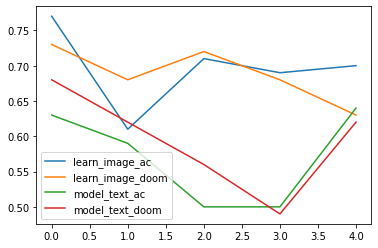

In [168]:
aux.plot.line()

In [ ]:
df_train, df_val = train_test_split(df, train_size=100)
df_val.loc[:, ['ac', 'doom']] = None
results = []
for i in range(5):
    images_train, images_test, text_train, text_test = get_sets(df_train, df_val)
    models = train_all_models(images_train, text_train)
    r = test_models(df_test, *models)
    results.append(r)
    print(f'------{i}--------')
    print_acc(df_test, *r)
    j = np.argmax(calculate_acc(df_test, *r))
    aux = asdf(models, j, df_val, N=100)
    df_val = df_val.drop(index=aux.index)
    df_train = pd.concat([df_train, aux])
aux = [calculate_acc(df_test, *r) for r in results]
aux = pd.DataFrame(aux, columns=['learn_image_ac', 'learn_image_doom', 'model_text_ac', 'model_text_doom'])
aux.to_csv('./results/n_100_5_100.csv')
aux.plot.line()

In [18]:
df_train, df_val = train_test_split(df, train_size=50)
df_val.loc[:, ['ac', 'doom']] = None
results = []
def asdf(models, p, df_val, N=10):
    aux = df_val.iloc[:N].copy()
    images_test, text_test = get_sets(aux)
    result = []
    result.append((images_test['path'].apply(lambda p: os.path.join(IMAGES_PATH, p)).apply(models[0].predict).apply(itemgetter(0)).apply(lambda s: s=='True') * 2 - 1) * p[0])
    result.append((images_test['path'].apply(lambda p: os.path.join(IMAGES_PATH, p)).apply(models[1].predict).apply(itemgetter(0)).apply(lambda s: s=='True') * 2 - 1) * p[1])
    for i in [2, 3]:
        label = 'ac' if i == 2 else 'doom'
        with torch.no_grad():
            test_dataset = TextDataset(text_test, 'ac', labeled=False)
            test_dataloader = DataLoader(
                test_dataset,
                batch_size=len(test_dataset) 
            )
            batch = list(test_dataloader)[0]
            out_ = models[i](
                batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=None
            )
            r = out_[0].numpy().argmax(axis=1)
            r = pd.Series(r, aux.index).apply(bool)
            r = (r * 2 - 1) * p[i] 
            result.append(r)
    result = (aux[0] + aux[2] - (aux[1] + aux[3])).apply(lambda i: i < 0)
    aux['ac'] = result
    aux['doom'] = -result
    return aux
results = []
for i in range(5):
    images_train, images_test, text_train, text_test = get_sets(df_train, df_val)
    models = train_all_models(images_train, text_train)
    r = test_models(df_test, *models)
    results.append(r)
    print(f'------{i}--------')
    print_acc(df_test, *r)
    aux = asdf(models, calculate_acc(df_test, *r), df_val, N=20)
    df_val = df_val.drop(index=aux.index)
    df_train = pd.concat([df_train, aux])

/home/cegf/.virtualenvs/new_aka_sl/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


epoch,train_loss,valid_loss,error_rate,time
0,1.310983,1.541512,0.600000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.347126,1.234398,0.500000,00:08
1,1.237232,1.359594,0.400000,00:07
2,0.936346,1.418213,0.400000,00:08
3,0.768494,1.440334,0.400000,00:08
4,0.638847,1.317611,0.400000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.096630,1.290527,0.400000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.284376,1.173763,0.400000,00:08
1,1.123502,0.915019,0.300000,00:08
2,0.855150,0.833825,0.200000,00:08
3,0.760692,0.807064,0.300000,00:08
4,0.628959,0.761368,0.200000,00:07


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.71

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.63

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.59

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.60

Training complete!


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.67

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.63

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.60

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.53

Training complete!


------0--------
Image AC: 0.58
Image DOOM: 0.61
Text AC: 0.46
Text DOOM: 0.57


KeyError: 0

In [ ]:
df_val